# Build a CV Train/Score/Evaluate Scaffold
* similar benefits as CI/CD pipeline
  * quickly try and validate new ideas
  * something to build on top of, e.g. feature selection
* start with ~1/2 of data
  * overfitting will occur--subsetting early mitigates some of this
* store all models and supporting data
* support various models
* bespoke strafified sampling for folds
* plotting routines for evaluation

## TODO
* save models to disk
* save tables
* metrics
* move variables --> dict --> model.json
* move boilerplate to boilerplate.ipynb

## Boilerplate

### Separate databases: __labels, models, features, cv__

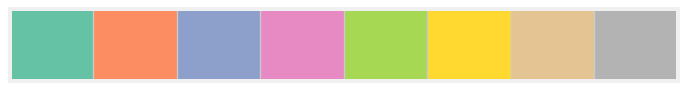

In [1]:
%run initialize.ipynb

import cPickle as pickle
import json

from pyspark.sql import Window

# spark.sql('CREATE DATABASE labels')
# spark.sql('CREATE DATABASE models')
# spark.sql('CREATE DATABASE features')
# spark.sql('CREATE DATABASE cv')

In [2]:
rcParams['figure.figsize'] = (12,8)
rcParams['figure.dpi'] = 96

# color_palette = 'Paired'
# colors = sns.color_palette(color_palette)
# sns.palplot(sns.color_palette(color_palette))
# rcParams['axes.prop_cycle'] = cycler(color=colors)

## Global Functions

#### Stratified sampling functions

In [3]:
def prop_dict_rolling(d):
    '''given a dictionary of probabilities, where
    the values are floats that sum to 1, 
    return a dictionary with the same keys, where
    the values are disjoint windows.
    usage note: top is inclusive. bottom is exclusive unless 0.
    usage note: if both elements are the same, skip'''
    rolling_sum = 0
    rolling = {}
    for k,v in d.iteritems():
        rolling[k] = (rolling_sum, rolling_sum+v)
        rolling_sum += v
    return rolling

def assign_group(df, d, strata_cols, colname):
    '''given (1) a dictionary of ranges,
    (2) a DF with random values ranked 
    by random block, and 
    (3) a name for the grouped columns,
    return DF with a new column that 
    assigns group membership'''
    
    window = Window.orderBy('dataset_rnd').partitionBy(*strata_cols)
    df = df.withColumn(
            'dataset_rk', F.percent_rank().over(window)
        )
    for i, (k,v) in enumerate(d.iteritems()):
        ## if the bottom is 0, make it -1 to include 0
        min_val = -1 if v[0] == 0 else min_val
        if i == 0:
            group_assign_cond = F.when(
                (col('dataset_rk') > min_val)
                & (col('dataset_rk') <= v[1]),
                F.lit(k)
            )
        else:
            group_assign_cond = group_assign_cond.when(
                (col('dataset_rk') > min_val)
                & (col('dataset_rk') <= v[1]),
                F.lit(k)
            )
    
    return df.withColumn(colname, group_assign_cond)

def modify_group_for_dim(df, d, colname):
    '''given a DF with a groups assigned (variable colname),
    apply a dictionary to post-process the groups according 
    to that one dimension. returns original DF with modified
    colname column.
    e.g. move specific seasons to the holdout or throwaway sets.
    '''
    for grp, grp_dict_list in dimensional_dataset_proportions.iteritems():
        for grp_dict in grp_dict_list:
            window = Window.orderBy('dim_rnd')\
                           .partitionBy(grp_dict['dim'], colname)
            df = df.withColumn('dim_rk', F.percent_rank().over(window))

            ## if (1) the column is within the set values,
            ## (2) the pre-existing group falls within those set values, and
            ## (3) the random value is below the set threshold,
            ## then override and modify the group membership
            df = df.withColumn(
                colname, 
                F.when(
                    (col(grp_dict['dim']).isin(grp_dict['vals']))
                    & (col(colname).isin(grp_dict['from_groups'])) 
                    & (col('dim_rk') >= grp_dict['prop']), 
                  grp
                ).otherwise(col(colname))
            )
    return df

#### Evaluation/Plotting Functions

In [4]:
def compute_bins(df, nbins, bin_type):
    '''given a pandas DF of scores and labels,
    compute nbins using either percentiles or 
    histogram style bins'''
    
    assert bin_type in ['Bin','Percentile'] 
    ## Bin into nbins bins
    if bin_type == 'Bin':
        df[bin_type] = df['score'].apply(
            lambda x: int(np.round(x*nbins, 0))
        )
    ## Bin by percentile
    elif bin_type == 'Percentile':
        df = df.sort_values(by='score')
        df['rk'] = np.arange(0, df.shape[0], 1)
        df['rk'] /= float(df.shape[0])
        df[bin_type] = df['rk'].apply(
            lambda x: int(np.round(x*nbins, 0))
        )

    scores_to_plot = spark.createDataFrame(df[[bin_type,'label']])

    ## reindex 0,1,2,...,100
    new_idx = np.arange(0, nbins+1, 1)

    return scores_to_plot.groupby(bin_type)\
                         .pivot('label')\
                         .count()\
                         .fillna(0)\
                         .toPandas()\
                         .rename(columns=label_map)\
                         .set_index(bin_type)\
                         .reindex(new_idx)\
                         .fillna(0)\
                         .sort_index()

def compute_plot_bins(df, nbins, label_map, bin_type, colors):
    '''given a pandas DF of bins, plot the bins
    overlaid on each other'''

    scores_colors = (colors[0], colors[3], colors[1], colors[2])

    for i, c in enumerate(df.columns.tolist()[::-1]):
        df[c].plot(kind='bar', rot=0, color=scores_colors[i], width=1, 
                   alpha = 0.75 - 0.25*i)
        
    plt.title('Distribution of Scores vs. Labels: Score {}s'.format(bin_type))
    plt.legend()
    plt.ylabel('Count')
    plt.xlabel('Score {}s'.format(bin_type))
    skipticks = int(np.ceil(nbins / 20.))
    a, b = plt.xticks()
    plt.xticks(a[::skipticks], b[::skipticks])
    plt.show()
    
def plot_trend(df, eval_dict, bin_type, nbins):
    import statsmodels.api as sm
    '''given binned pandas DF, and dict defining
    success, return a bar chart of success by score bin
    and trendlines to indicate whether higher scores correlate
    with greater success'''
    success_col = eval_dict['success_col']
    failure_col = eval_dict['failure_col']
    success_name = eval_dict['success_name']
    df['success'] = df[success_col].astype(float) \
                    / ( df[success_col] + df[failure_col] )

    ax = plt.figure().add_subplot(111)
    ## plot bar chart of win rate by bin
    df['success'].plot(
        kind='bar', color=colors[2], rot=0, alpha = 0.75, ax=ax,
        title='{} By {}'.format(success_name, bin_type), 
        label='Actual {}'.format(success_name)
    )
    
    ## ols method doesn't take columns with sapces
    bin_type_nospace = bin_type.replace(' ','_')
    scores_trend = df.reset_index(drop=False)\
                     .loc[:, [bin_type,'success']]\
                     .rename(columns={ bin_type:bin_type_nospace })
    
    ## Fit OLS model    
    linreg = sm.formula.ols(
        formula='success ~ {}'.format(bin_type_nospace), 
        data=scores_trend
    )
    
    res = linreg.fit()
    scores_trend = scores_trend.assign(OLS=res.fittedvalues)

   ## LOWESS Trends (wider window and tigher window)
    lowess = sm.nonparametric.lowess

    lowess_wide = lowess(
            scores_trend['success'], 
            scores_trend[bin_type_nospace], 
            frac = 2./3
        )
    lowess_tight = lowess(
            scores_trend['success'], 
            scores_trend[bin_type_nospace], 
            frac=1/np.sqrt(nbins)
        )

    ## assign method takes **kwargs in the form of 
    ## new column name: column definition
    scores_trend = scores_trend.assign(
        **{'LOWESS Wide Window': lowess_wide[:,1],
           'LOWESS Tight Window': lowess_tight[:,1]}
    )

    ## plot trendlines
    scores_trend['OLS'].plot(kind='line', ax=ax, color=colors[1])
    scores_trend['LOWESS Wide Window'].plot(
                kind='line', ax=ax, color=colors[0]
            )
    scores_trend['LOWESS Tight Window'].plot(
                kind='line', ax=ax, color=colors[4]
            )
    
    skipticks = int(np.ceil(nbins / 20.))
    plt.legend()
    plt.ylabel(success_name)
    plt.xlabel('Score {}s'.format(bin_type))    
    a, b = plt.xticks()
    plt.xticks(a[::skipticks], b[::skipticks])
    plt.show()

In [5]:
def plot_single_roc_curve(df, tprs, aucs, mean_fpr, i, set_name):
    '''given pandas DF of label and score,
    compute ROC values and add to current plot.
    append appropriate values to trps and aucs'''
    from sklearn.metrics import roc_curve, auc
    from scipy import interp
    
    fpr, tpr, thresholds = roc_curve(df['label'], df['score'])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    _ = plt.plot(fpr, tpr, lw=0.5, alpha=0.5, color=colors[i+1],
             label='ROC {} (AUC = {:.2f})'.format(set_name, roc_auc))
    
def roc_plot_kfold_errband(roc_sets):
    '''plot ROC curves, with curves and AUCs 
    for each of the K folds, the mean curve/AUC, 
    and error band'''
    from sklearn.metrics import auc
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (set_nbr, df) in enumerate(roc_sets.iteritems()):
        ## plot a single ROC curve
        ## and append to tprs and aucs
        plot_single_roc_curve(
                df, tprs, aucs, mean_fpr, i, 'Fold {}'.format(i)
            )

    ## random (as good as random guessing)
    _ = plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color=colors[-1],
             label='Always Predict Majority Class', alpha=0.8)

    ## compute mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    _ = plt.plot(mean_fpr, mean_tpr, color=colors[0],
             label=r'Mean ROC (AUC = {:.2f} $\pm$ {:.2f})'.format(mean_auc, std_auc),
             lw=2, alpha=.8)

    ## add error bands, +/- 1 stddev
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    _ = plt.fill_between(
        mean_fpr, tprs_lower, tprs_upper, color=colors[-1], 
        alpha=0.2, label=r'$\pm$ 1 std. dev.'
    )

    ## modify plot attributes
    _ = plt.xlim([-0.05, 1.05])
    _ = plt.ylim([-0.05, 1.05])
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('ROC Curve')
    _ = plt.legend(loc="lower right")
    plt.show()

In [6]:
def plot_by_threshold(df, metric):
    '''given a pandas DF of scores, 
    compute and plot the accuracy, 
    given score thresholds
    0.00,0.01,0.02,...,1.00'''
    from sklearn.metrics import f1_score, accuracy_score
    
    acc_curve = {}
    for i in np.arange(0, 1.01, 0.01):
        df['pred'] = (df['score'] >= i).astype(int)
        
        if metric == 'Accuracy':
            acc_curve[i] = accuracy_score(df['label'], df['pred'])
        elif metric == 'F1':
            acc_curve[i] = f1_score(df['label'], df['pred'])

    acc_df = pd.DataFrame\
               .from_dict(acc_curve, orient='index')\
               .sort_index()\
               .rename(columns={0:metric})
    acc_df.index.name = 'Model Score'

    peak = acc_df.loc[acc_df.idxmax()]
    peak_score = peak.index[0]
    peak_acc = peak.iloc[0,0]
    x0_50_acc = acc_df.loc[0.50, metric]

    _ = acc_df.plot(
        kind='line', 
        title='{} at Different Classifaction Thresholds'.format(metric)
    )
    _ = plt.axhline(
        y=peak_acc, xmin=0, xmax=1, 
        label='Score {:.3f} | {} {:.3f} (Peak)'
                  .format(peak_score, metric, peak_acc),
        linewidth=2, color=colors[2]
    )
    _ = plt.axhline(
        y=acc_df.loc[0.50, metric], xmin=0, xmax=1, 
        label='Score 0.50 | {} {:.3f}'.format(metric, x0_50_acc),
        linewidth=2, color=colors[3]
    )
    _ = plt.legend()
    _ = plt.ylabel(metric)

## Simple Spread Model

### Labels
* did_win

### Features
* season
* week_id
* is_home
* dave_or_wtddvoa
* offensedvoa
* defensedvoa
* s_t_dvoa

### Generate Test Data -- this would be done ahead of time

In [7]:
ranks = spark.table('dvoa').select(
        'team_id','season','week_id','dave_or_wtddvoa',
        'offensedvoa','defensedvoa','s_t_dvoa'
    ).cache()
game_feats = spark.table('team_game_line_labels').select(
        'game_id','season','week_id','team_id','is_home'
    ).cache()

features = game_feats.join(
        ranks, on=['team_id','season','week_id']
    )
labels = spark.table('team_game_line_labels').select(
    ## index
    'game_id','team_id',
    ## strata
    'is_home','is_fav_sbr',
    ## labels
    'did_win','final_margin','did_cover_pfr',
    'did_cover_sbr','did_cover_sbr_open'
)

assert features.count() == labels.count()

In [8]:
features.write.mode('overwrite').saveAsTable('features.0109_test')
labels.write.mode('overwrite').saveAsTable('labels.0109_test')

### Train and Score Model

#### Define variables -- eventually for model.json

In [84]:
model_dict = {
    'model_id': '0111_did_win_initial',
    'features_tbl': 'features.0109_test',
    'labels_tbl': 'labels.0109_test',
    'features_list': [
        'season',
        'week_id',
        'is_home',
        'dave_or_wtddvoa',
        'offensedvoa',
        'defensedvoa',
        's_t_dvoa'
    ],
    'label_col': 'did_win',
    'pos_labels': [1],
    'neg_labels': [-1],
    'index': ['game_id','team_id'],
    'nfolds': 1,
    'kfold_seed': 99,
    'dataset_seed': 9,
    'strata_cols': ['did_win','is_home'],
    'global_dataset_proportions': {
        'holdout': 0.5,
        'throw_away': 0,
        'in_training': 0.35,
        'scoring_only': 0.15
    },
    'dimensional_dataset_proportions': {
    'throw_away': [{
        'dim': 'is_home',
        'from_groups': ['in_training','holdout','scoring_only'],
        'vals': [0],
        'prop': 0.0
    }]
    },
    'model_seed': 9,
    'model': 'xgboost.XGBClassifier',
    'model_params': {
        'booster':'gbtree',
        'gamma': 0,
        'learning_rate': 0.1,
        'max_depth': 3,
        'max_features': 'auto',
        'n_estimators': 200,
        'n_jobs': 1,
        'nthread': None,
        'objective': 'binary:logistic',
        'random_state': model_seed,
        'silent': True,
        'subsample': 0.9
    }    
}

In [85]:
model_json = json.dumps(model_dict)

In [39]:
# model_id = '0111_did_win_initial'

# features_tbl = 'features.0109_test'
# labels_tbl = 'labels.0109_test'

# features_list = [
#     'season',
#     'week_id',
#     'is_home',
#     'dave_or_wtddvoa',
#     'offensedvoa',
#     'defensedvoa',
#     's_t_dvoa'
# ]

# label_col = 'did_win'
# pos_labels = [1]
# neg_labels = [-1]

# index = ['game_id','team_id']

# nfolds = 1
# kfold_seed = 99

# dataset_seed = 9
# strata_cols = ['did_win','is_home']

# ## this says holdout 50%, and the other 50% goes in training
# global_dataset_proportions = {
#     'holdout': 0.5,
#     'throw_away': 0,
#     'in_training': 0.35,
#     'scoring_only': 0.15
# }

# ## this says to throw away all games where 
# ## team is Visitor
# dimensional_dataset_proportions = {
#     'throw_away': [{
#         'dim': 'is_home',
#         'from_groups': ['in_training','holdout','scoring_only'],
#         'vals': [0],
#         'prop': 0.0
#     }]
    
# }

# model_seed = 9
# model = 'xgboost.XGBClassifier'
# model_params = {
#     'booster':'gbtree',
#     'gamma': 0,
#     'learning_rate': 0.1,
#     'max_depth': 3,
#     'max_features': 'auto',
#     'n_estimators': 200,
#     'n_jobs': 1,
#     'nthread': None,
#     'objective': 'binary:logistic',
#     'random_state': model_seed,
#     'silent': True,
#     'subsample': 0.9
# }

#### Assertions on model.json variables

In [40]:
assert sum(global_dataset_proportions.values()) == 1
assert type(global_dataset_proportions) is dict
for d in dimensional_dataset_proportions.values():
    assert type(d) is list
    assert sum([type(x) is not dict for x in d]) == 0
    
## other assertions
# tables exists
# columns are in tables
# 

#### Select data and assign random values for binning

In [41]:
features_prep = spark.table(features_tbl).select(
        *( set(features_list) | set(index) )
    )
labels_prep = spark.table(labels_tbl).select(
        *( set(index) | set(strata_cols) | set([label_col]) )
    )

labels_prep = labels_prep.withColumn(
        'dataset_rnd', F.rand(dataset_seed)
    ).withColumn(
        'dim_rnd', F.rand(dataset_seed)
    ).withColumn(
        'kfold_rnd', F.rand(kfold_seed)
    ).withColumn(
        'label', 
        F.when(col(label_col).isin(pos_labels), 1)
         .when(col(label_col).isin(neg_labels), 0)
         .otherwise(None)
    ).filter(
        col('label').isNotNull()
    )

#### Apply stratified sampling
* TODO: pre-bin the values (either by percentile/decile/quantile/etc, or by defined groups) if requested. purely a nice-to-have
* move to a function
* 4 uses for strata
 * holdout
 * throw away
 * in training folds or scoring only
 * k-fold
* techniques
 * for k-fold, it's easy as it's uniform across folds
 * holdout/throw away/in training/score only can be performed together
* options
 * global: cut the count by this proportion, for all blocks
 * dimensional: after the global cut, further cut a single dimensional value
   * e.g. could be used to remove certain years or weeks
   * for now, this will be manual after the dict is created
   * or have skip_values dict of column: [values] to 0 out

apply global proportions

In [42]:
global_rolling = prop_dict_rolling(global_dataset_proportions)
datasets = assign_group(labels_prep, global_rolling, strata_cols, 'dataset')

datasets.groupby('did_win','is_home').pivot('dataset').count().toPandas()

,did_win,is_home,holdout,in_training,scoring_only
0,1,NaN,19,13,6
1,1,0.0,616,432,185
2,-1,1.0,616,432,185
3,1,1.0,830,581,249
4,-1,NaN,19,13,6
5,-1,0.0,830,581,249


apply dimensional proportions

In [43]:
datasets = modify_group_for_dim(
    datasets, dimensional_dataset_proportions, 'dataset' 
)

datasets.groupby('did_win','is_home').pivot('dataset').count().toPandas().fillna(0)

,did_win,is_home,holdout,in_training,scoring_only,throw_away
0,1,0.0,19.0,13.0,6.0,0.0
1,1,0.0,0.0,0.0,0.0,1233.0
2,-1,1.0,616.0,432.0,185.0,0.0
3,1,1.0,830.0,581.0,249.0,0.0
4,-1,0.0,19.0,13.0,6.0,0.0
5,-1,0.0,0.0,0.0,0.0,1660.0


#### Stratified Sampling -- CV Set -- TODO: what if no folds desired, e.g. 70/30 split, 1 model

In [44]:
scoring_rows = datasets.filter(col('dataset') == 'scoring_only')
training_rows = datasets.filter(col('dataset') == 'in_training')

In [45]:
## assign K folds
if nfolds > 1:
    folds_dict = {k: 1./nfolds for k in np.arange(nfolds)}
    folds_rolling = prop_dict_rolling(folds_dict)
    training_rows = assign_group(training_rows, folds_rolling, strata_cols, 'fold')

    training_rows.groupby('did_win','is_home').pivot('fold').count().toPandas()
else:
    training_rows = training_rows.withColumn('fold', F.lit(0))

In [47]:
training_rows.groupby('did_win','is_home').pivot('fold').count().toPandas().fillna(0)

,did_win,is_home,0
0,1,0.0,13
1,-1,1.0,432
2,1,1.0,581
3,-1,0.0,13


In [48]:
training = features_prep.join(
    training_rows.select(*(index + ['label','fold'])),
    on=index
)
scoring_only = features_prep.join(
    scoring_rows.select(*(index + ['label'])),
    on=index
)

assert training.count() == training_rows.count()
assert scoring_only.count() == scoring_rows.count()

In [49]:
training.limit(5).toPandas()
scoring_only.limit(5).toPandas()

,game_id,team_id,week_id,defensedvoa,dave_or_wtddvoa,season,offensedvoa,is_home,s_t_dvoa,label,fold
0,200811090mia,mia,10,-3.0,10.6,2008,14.9,1.0,-8.5,1,0
1,200811160mia,mia,11,-0.5,10.1,2008,15.3,1.0,-8.2,1,0
2,200811230mia,mia,12,0.5,6.6,2008,16.7,1.0,-9.4,0,0
3,200812140mia,mia,15,2.4,8.5,2008,14.6,1.0,-6.8,1,0
4,200901040mia,mia,18,3.0,7.5,2008,17.1,1.0,-4.9,0,0


,game_id,team_id,week_id,defensedvoa,dave_or_wtddvoa,season,offensedvoa,is_home,s_t_dvoa,label
0,200811030was,was,9,-3.3,20.4,2008,19.9,1.0,-2.7,0
1,200810190kan,kan,7,16.1,-46.4,2008,-38.2,1.0,-3.2,0
2,200810260htx,htx,8,29.8,-19.6,2008,2.4,1.0,3.5,1
3,200811020cin,cin,9,17.1,-45.8,2008,-25.7,1.0,-2.7,1
4,200811300cin,cin,13,9.1,-27.2,2008,-16.1,1.0,-2.9,0


#### Train K Folds and Score

In [50]:
import importlib

model_obj_path = '.'.join(model.split('.')[:-1])
model_name = model.split('.')[-1]
model_package = importlib.import_module(model_obj_path)
model_class = getattr(model_package, model_name)

## as opposed to spark:
train_in_memory = model.split('.')[0] in ['sklearn','xgboost']

#### Future TODO: support Spark ML

In [70]:
if train_in_memory is True:
    training_df = training.toPandas().set_index(index)
    scoring_only_df = scoring_only.toPandas().set_index(index)
    
    ## folds
    training_scoring_sets  = {
        f: {'train': training_df[training_df['fold'] != f],
            'score': training_df[training_df['fold'] == f]}
        for f in np.arange(nfolds)
    }
    ## full sets
    training_scoring_sets['full'] = {
        'train': training_df,
        'score': scoring_only_df
    }

    cv_models = {
        set_nbr: model_class(
                **model_params
            ).fit(
                np.array(set_data['train'][features_list].values.tolist()),
                set_data['train']['label'].ravel()
            )
        # for fold 0, 1, ... and full set
        for set_nbr, set_data in training_scoring_sets.iteritems()
        # skip training the full set if there's no scoring data
        if min(set_data['score'].shape[0], set_data['train'].shape[0]) > 0
    }
    
    ## TODO: pickle.dump, line 246 of train2.png
    for i, (set_nbr, mdl) in enumerate(cv_models.iteritems()):
        curr_scoring = training_scoring_sets[set_nbr]['score']
        curr_scoring['score'] = mdl.predict_proba(
                curr_scoring[features_list].values.tolist()
            )[:,1]
        
        if i == 0:
            scores_df = curr_scoring
        else:
            scores_df = scores_df.append(curr_scoring)

In [71]:
cv_models.keys()

['full']

### Evaluate Data and Plot Scores

#### plots.json variables

In [72]:
plot_bins = [10, 100]
label_map = {
    '0': 'Lost',
    '1': 'Won'
}
bin_types = ['Bin','Percentile']

eval_dict = {
    'success_name': 'Win Rate',
    'success_col': 'Won',
    'failure_col': 'Lost'
}

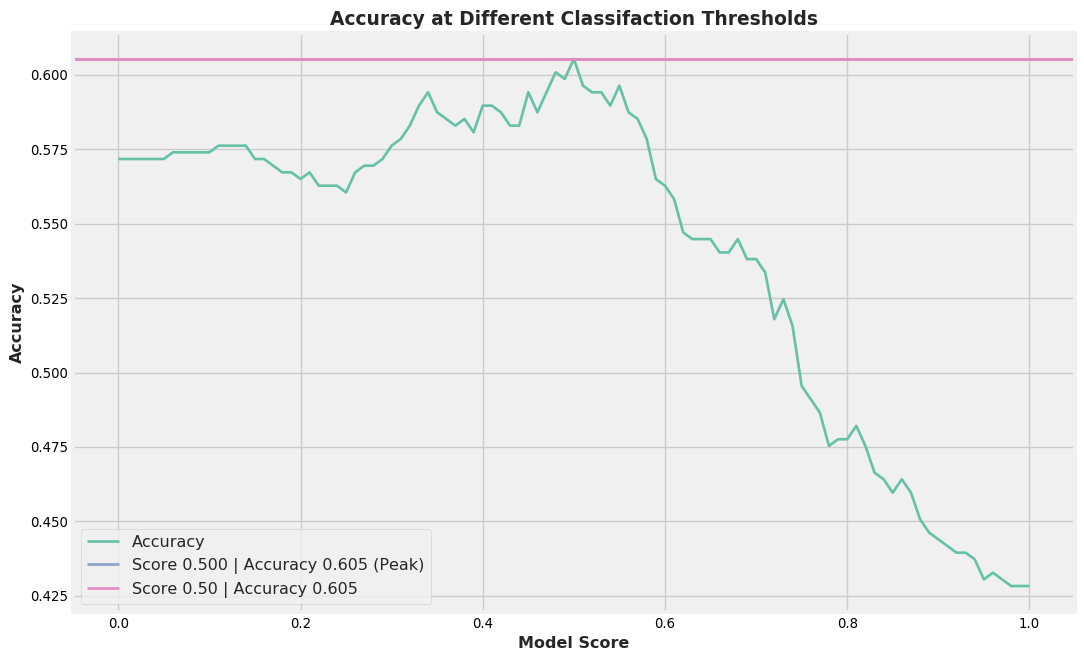

In [73]:
plot_by_threshold(scores_df, 'Accuracy')

/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


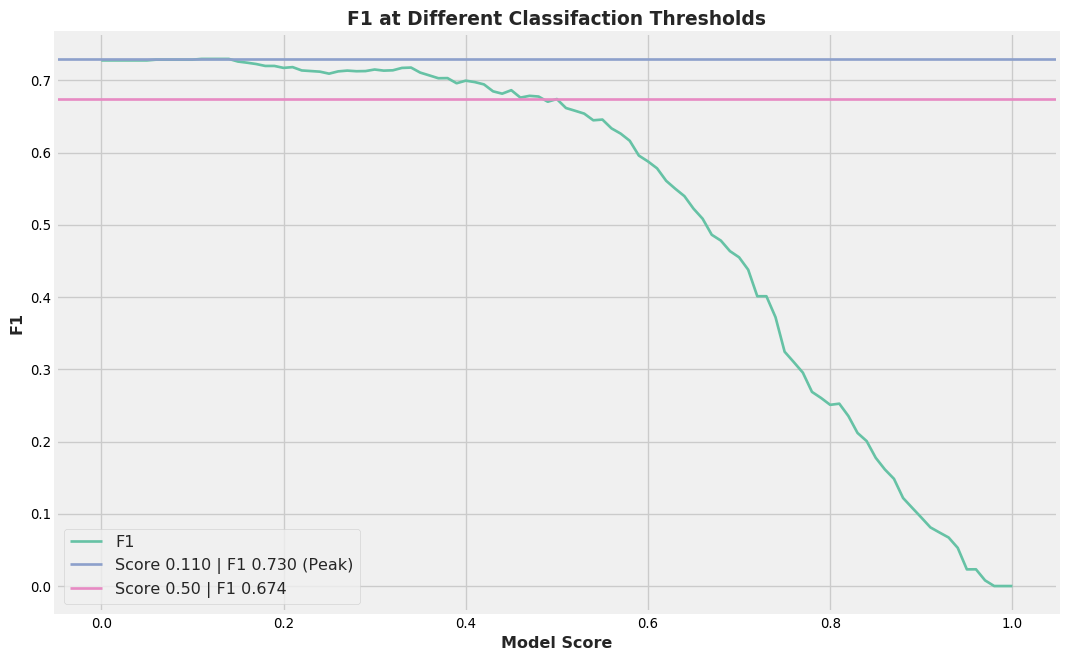

In [74]:
plot_by_threshold(scores_df, 'F1')

#### Plot distributions

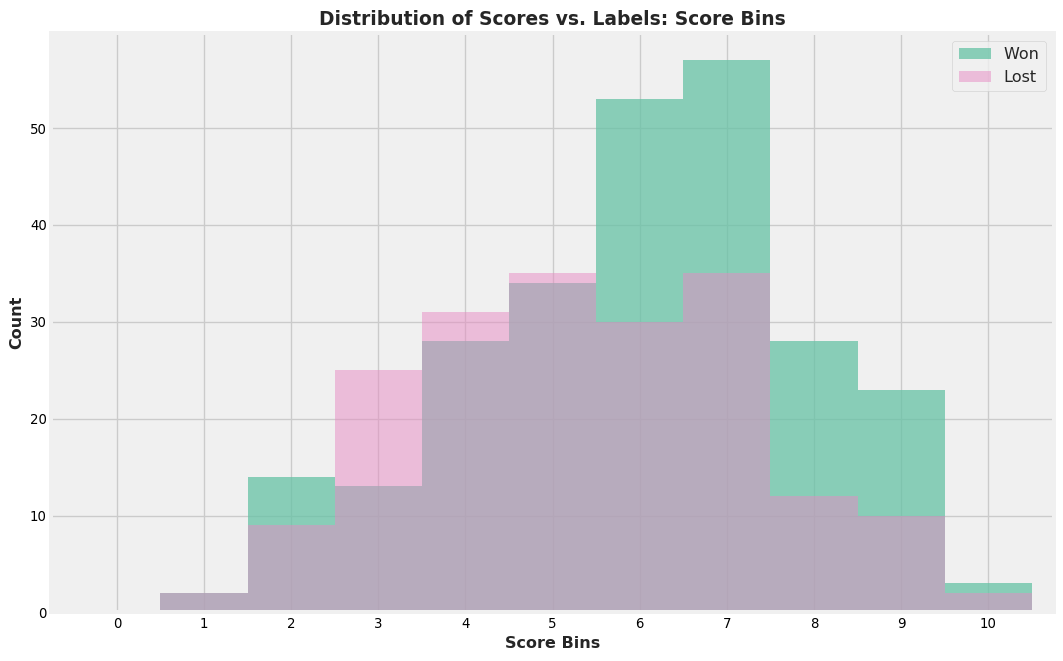

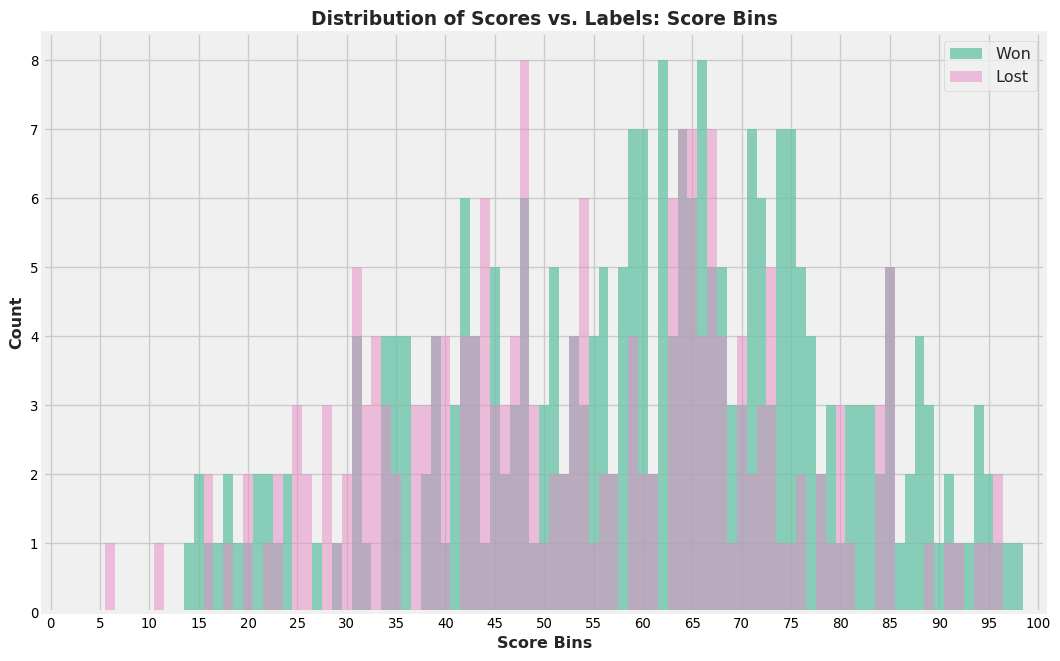

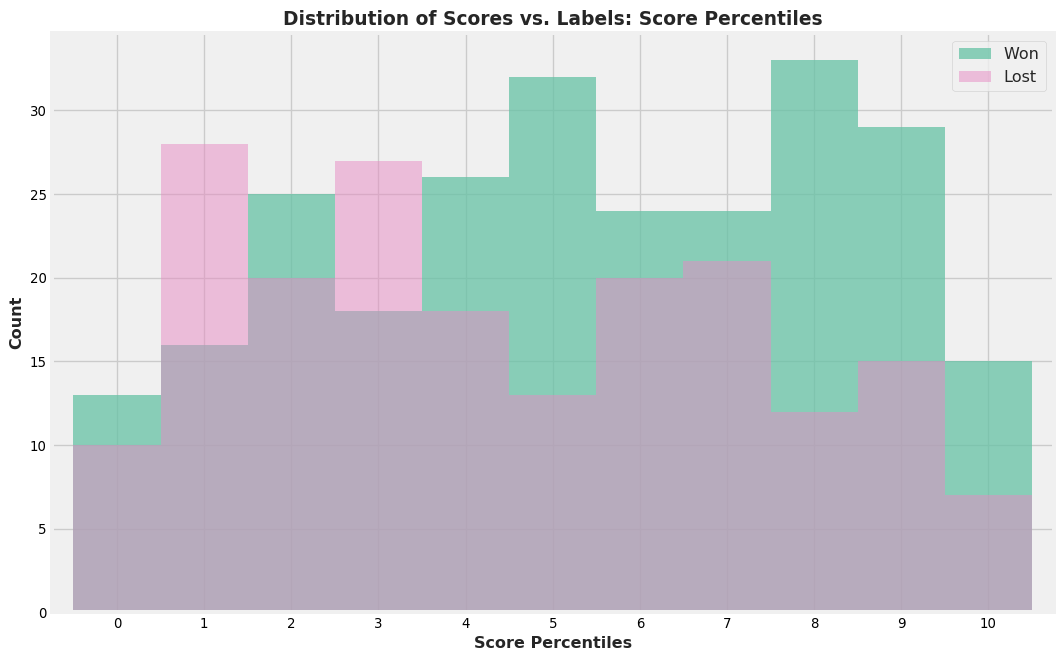

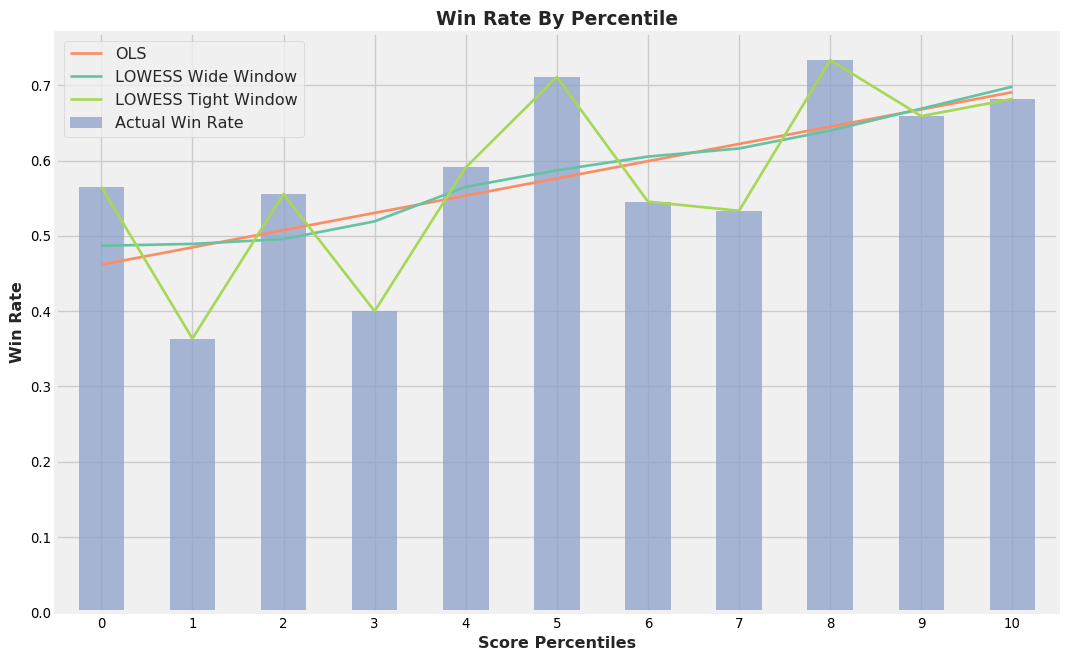

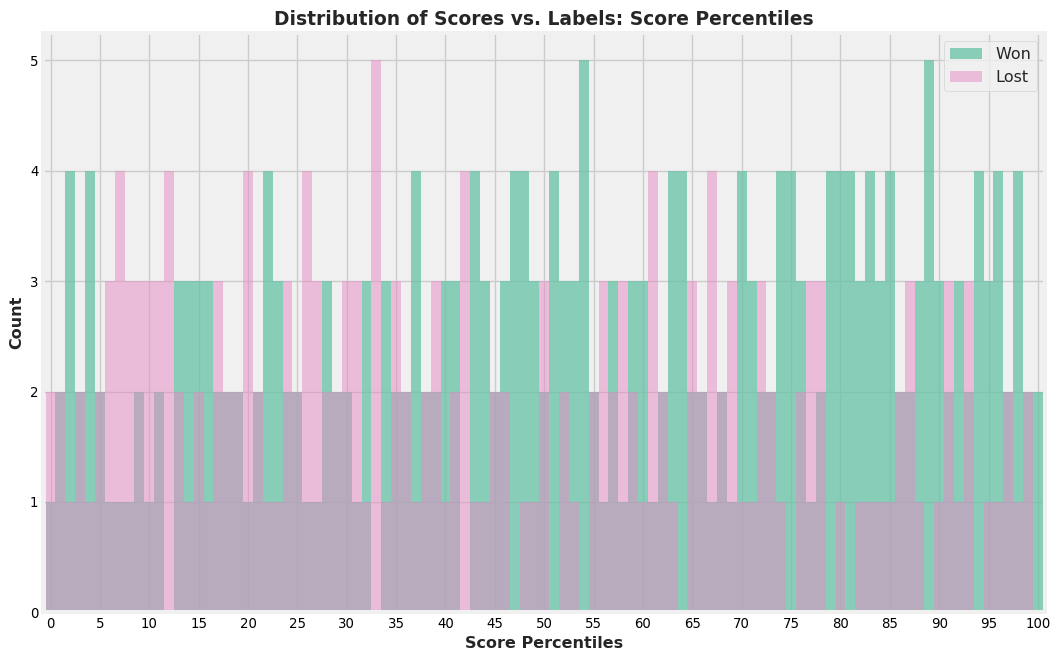

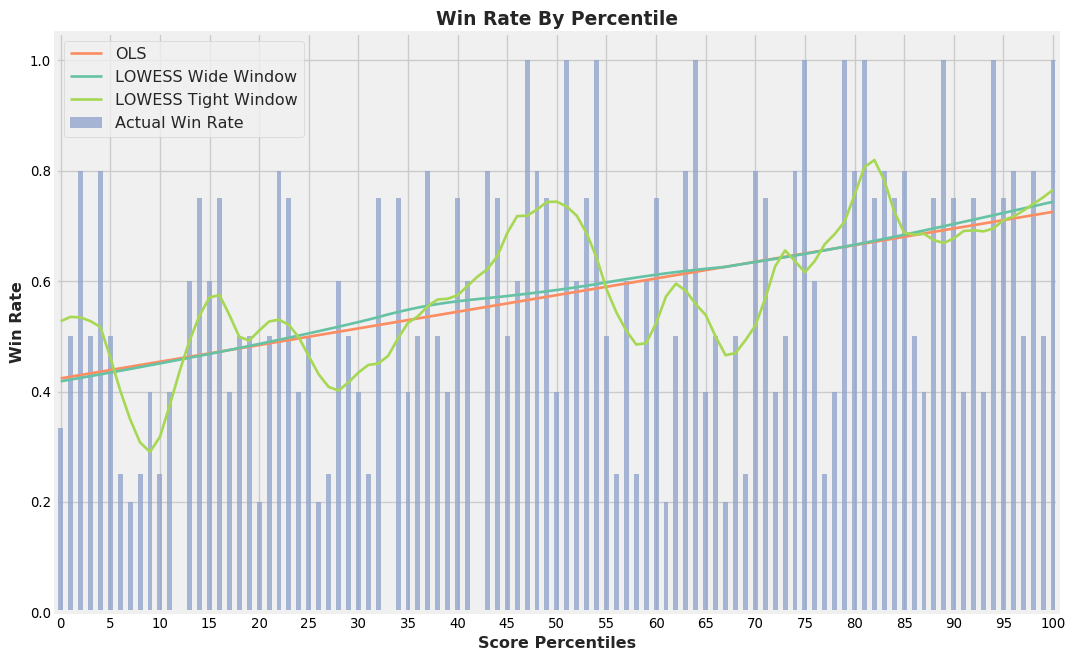

In [75]:
binned_data = {}
for bin_type in bin_types:
    binned_data[bin_type] = {}
    for nbins in plot_bins:
        ## plot bins
        curr_bins = compute_bins(scores_df, nbins, bin_type)
        compute_plot_bins(curr_bins, nbins, label_map, bin_type, colors)
        ## plot trend
        if bin_type == 'Percentile':
            plot_trend(curr_bins, eval_dict, bin_type, nbins)
        ## store data
        binned_data[bin_type][nbins] = curr_bins

#### ROC

In [78]:
training_scoring_sets.keys()
cv_models.keys()

[0, 'full']

['full']

['full']

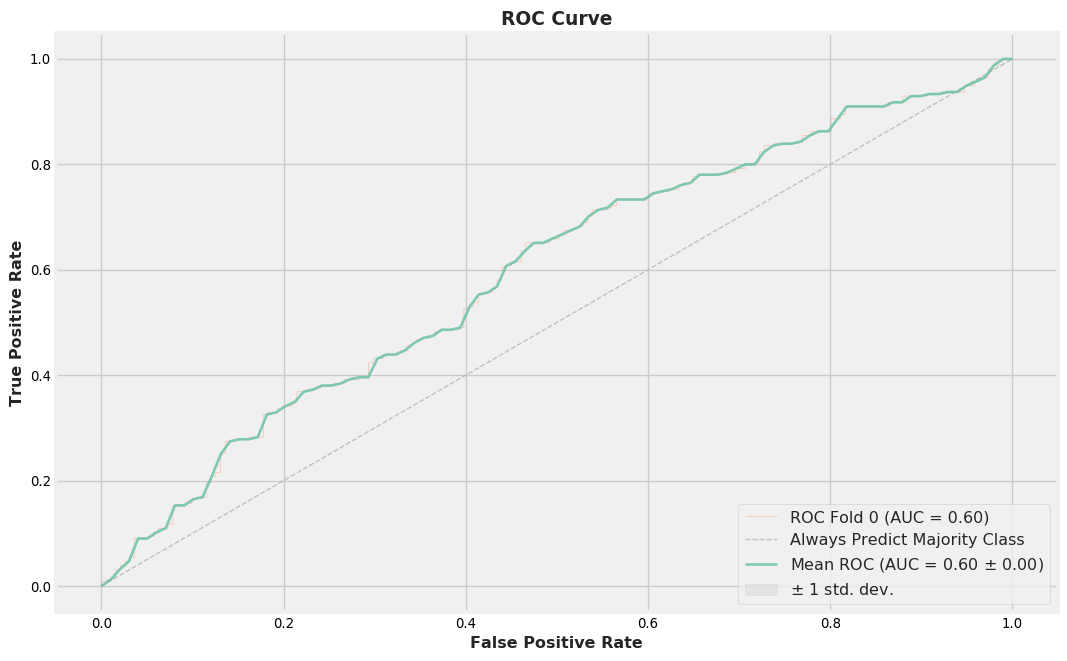

In [80]:
roc_sets = {
    set_nbr: set_data['score'][['label','score']]
    for set_nbr, set_data in training_scoring_sets.iteritems()
    if (set_data['score'].shape[0] > 0) & (set_nbr in cv_models.keys())
}

roc_plot_kfold_errband(roc_sets)

#### Feature importance

#### Feature contribution

#### Evaluation, e.g. super contest style

## Simple Over/Under Model

In [25]:
spark.table('over_under_labels').limit(5).toPandas()

,game_id,season,week_id,sbr_ou,pfr_ou,tot_score,is_sbr_ou_over,is_pfr_ou_over,is_sbr_ou_open_over
0,201511150ram,2015,10,42.0,42.5,50,-1,-1,-1
1,201511090sdg,2015,9,49.5,49.5,41,1,1,1
2,201510180det,2015,6,45.0,44.0,71,-1,-1,-1
3,201512270tam,2015,16,43.5,45.0,47,-1,-1,-1
4,201510110kan,2015,5,43.5,45.0,35,1,1,1


In [26]:
spark.table('game_metadata').limit(5).toPandas().T

,0,1,2,3,4
game_id,200909140nwe,200911150oti,200912270atl,200912130kan,201001030min
day_of_week,0,6,6,6,6
duration,3:03,3:05,3:02,3:02,3:50
prf_weather,"70 degrees relative humidity 53%, wind 5 mph, ...","68 degrees relative humidity 50%, wind 5 mph",nan,"42 degrees relative humidity 80%, wind 3 mph, ...",nan
roof,outdoors,outdoors,dome,outdoors,dome
surface,fieldturf,grass,fieldturf,grass,fieldturf
time,7:10pm,1:02pm,1:02pm,1:00pm,1:05pm
attendance,68756,69143,68887,68668,63854


#### Generate Test Data -- this would be done ahead of time

In [27]:
features = spark.table('over_under_labels').select(
        'game_id','season','week_id', 'sbr_ou'
    ).cache()

labels = spark.table('over_under_labels').select(
    ## index
    'game_id',
    ## strata
    ## label
    'is_sbr_ou_over'
)

assert features.count() == labels.count()

In [28]:
features.write.mode('overwrite').saveAsTable('features.0111_ou_test')
labels.write.mode('overwrite').saveAsTable('labels.0111_ou_test')

#### Model.json variables

In [29]:
features_tbl = 'features.0111_ou_test'
labels_tbl = 'labels.0111_ou_test'

features_list = ['season','week_id', 'sbr_ou']

label_col = 'is_sbr_ou_over'
pos_labels = [1]
neg_labels = [-1]

index = ['game_id']

nfolds = 5
kfold_seed = 99

dataset_seed = 9
strata_cols = []

## this says holdout 50%, and the other 50% goes in training
global_dataset_proportions = {
    'holdout': 0.5,
    'throw_away': 0,
    'in_training': 0.5,
    'scoring_only': 0
}

## this says to throw away all games where 
## team is Visitor
dimensional_dataset_proportions = {}

model_seed = 9
model = 'xgboost.XGBClassifier'
model_params = {
    'booster':'gbtree',
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 3,
    'max_features': 'auto',
    'n_estimators': 200,
    'n_jobs': 1,
    'nthread': None,
    'objective': 'binary:logistic',
    'random_state': model_seed,
    'silent': True,
    'subsample': 0.9
}

#### Train/Score

In [30]:
features_prep = spark.table(features_tbl).select(
        *( set(features_list) | set(index) )
    )
labels_prep = spark.table(labels_tbl).select(
        *( set(index) | set(strata_cols) | set([label_col]) )
    )

labels_prep = labels_prep.withColumn(
        'dataset_rnd', F.rand(dataset_seed)
    ).withColumn(
        'dim_rnd', F.rand(dataset_seed)
    ).withColumn(
        'kfold_rnd', F.rand(kfold_seed)
    ).withColumn(
        'label', 
        F.when(col(label_col).isin(pos_labels), 1)
         .when(col(label_col).isin(neg_labels), 0)
         .otherwise(None)
    ).filter(
        col('label').isNotNull()
    )

global_rolling = prop_dict_rolling(global_dataset_proportions)
datasets = assign_group(labels_prep, global_rolling, strata_cols, 'dataset')
datasets = modify_group_for_dim(
    datasets, dimensional_dataset_proportions, 'dataset' 
)

datasets.groupby(label_col).pivot('dataset').count().toPandas()

,is_sbr_ou_over,holdout,in_training
0,1,717,723
1,-1,729,724


In [31]:
scoring_rows = datasets.filter(col('dataset') == 'scoring_only')
training_rows = datasets.filter(col('dataset') == 'in_training')

In [32]:
## assign K folds
if nfolds > 1:
    folds_dict = {k: 1./nfolds for k in np.arange(nfolds)}
    folds_rolling = prop_dict_rolling(folds_dict)
    training_rows = assign_group(training_rows, folds_rolling, strata_cols, 'fold')

    training_rows.groupby(label_col).pivot('fold').count().toPandas()
else:
    training_rows = training_rows.withColumn('fold', F.lit(0))

,is_sbr_ou_over,0,1,2,3,4
0,1,151,148,145,139,140
1,-1,139,141,144,150,150


In [33]:
training = features_prep.join(
    training_rows.select(*(index + ['label','fold'])),
    on=index
)
scoring_only = features_prep.join(
    scoring_rows.select(*(index + ['label'])),
    on=index
)

assert training.count() == training_rows.count()
assert scoring_only.count() == scoring_rows.count()

In [34]:
training.limit(5).toPandas()
scoring_only.limit(5).toPandas()

,game_id,season,week_id,sbr_ou,label,fold
0,201510180det,2015,6,45.0,0,3
1,201512270tam,2015,16,43.5,0,0
2,201512200min,2015,15,44.0,0,1
3,201601030gnb,2015,17,44.0,1,0
4,201510250det,2015,7,44.5,0,1


,game_id,season,week_id,sbr_ou,label


In [35]:
import importlib

model_obj_path = '.'.join(model.split('.')[:-1])
model_name = model.split('.')[-1]
model_package = importlib.import_module(model_obj_path)
model_class = getattr(model_package, model_name)

## as opposed to spark:
train_in_memory = model.split('.')[0] in ['sklearn','xgboost']

In [36]:
if train_in_memory is True:
    training_df = training.toPandas().set_index(index)
    scoring_only_df = scoring_only.toPandas().set_index(index)
    
    ## folds
    training_scoring_sets  = {
        f: {'train': training_df[training_df['fold'] != f],
            'score': training_df[training_df['fold'] == f]}
        for f in np.arange(nfolds)
    }
    ## full sets
    training_scoring_sets['full'] = {
        'train': training_df,
        'score': scoring_only_df
    }

    cv_models = {
        set_nbr: model_class(
                **model_params
            ).fit(
                np.array(set_data['train'][features_list].values.tolist()),
                set_data['train']['label'].ravel()
            )
        # for fold 0, 1, ... and full set
        for set_nbr, set_data in training_scoring_sets.iteritems()
        # skip training the full set if there's no scoring data
        if set_data['score'].shape[0] > 0
    }
    
    ## TODO: pickle.dump, line 246 of train2.png
    for i, (set_nbr, mdl) in enumerate(cv_models.iteritems()):
        curr_scoring = training_scoring_sets[set_nbr]['score']
        curr_scoring['score'] = mdl.predict_proba(
                curr_scoring[features_list].values.tolist()
            )[:,1]
        
        if i == 0:
            scores_df = curr_scoring
        else:
            scores_df = scores_df.append(curr_scoring)

/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Plot

In [37]:
plot_bins = [10, 100]
label_map = {
    '0': 'Lost',
    '1': 'Won'
}
bin_types = ['Bin','Percentile']

eval_dict = {
    'success_name': 'Win Rate',
    'success_col': 'Won',
    'failure_col': 'Lost'
}

/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joshplotkin/anaconda2/lib/pyt

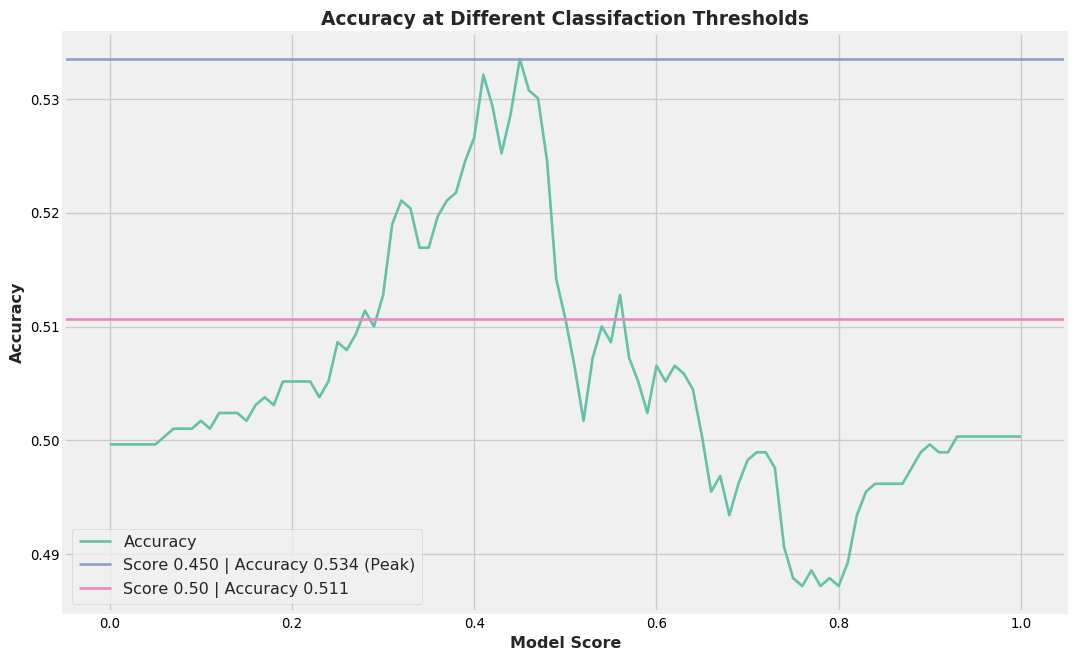

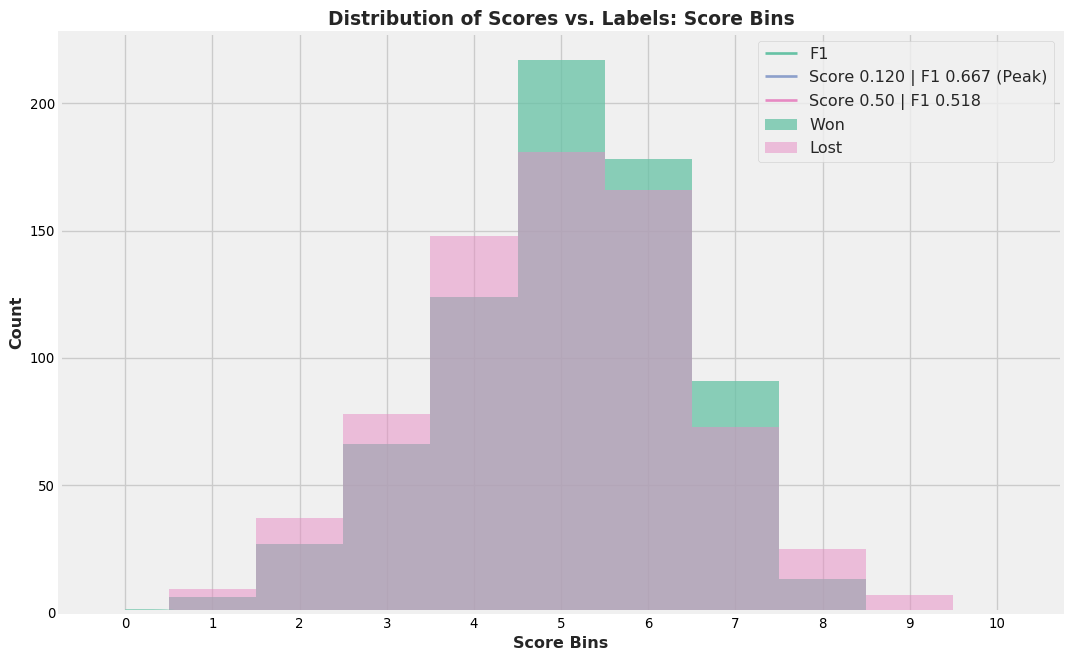

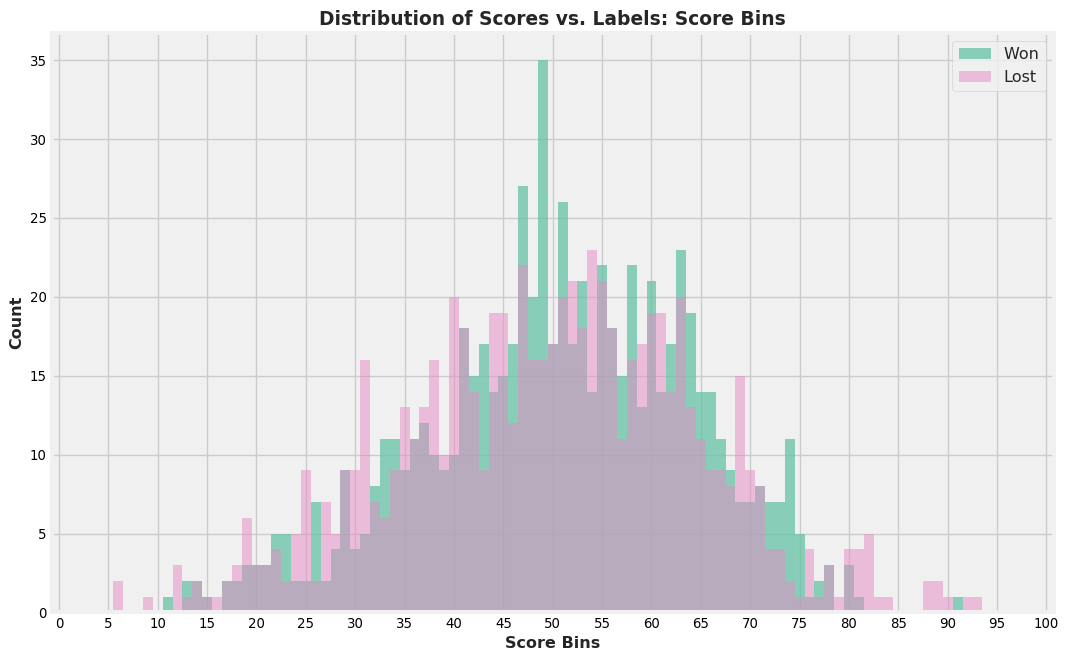

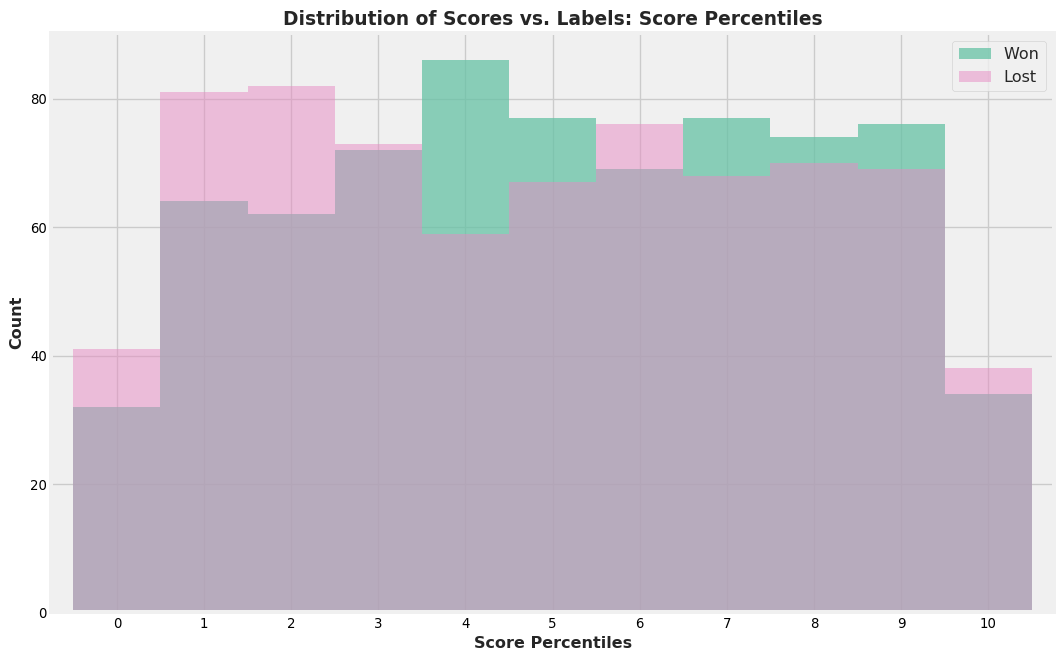

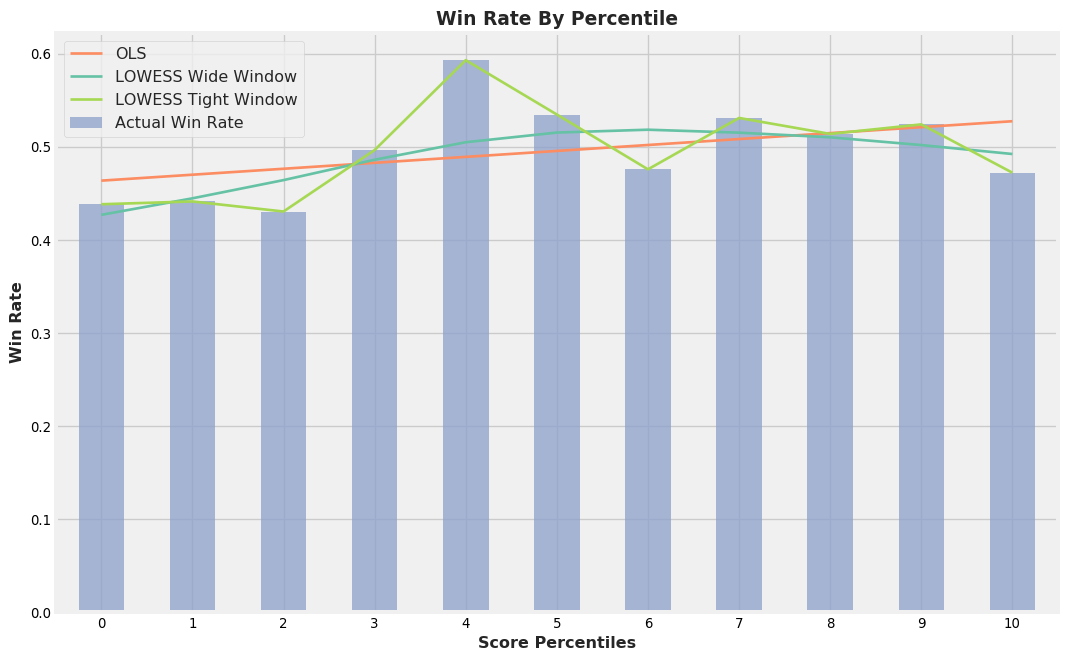

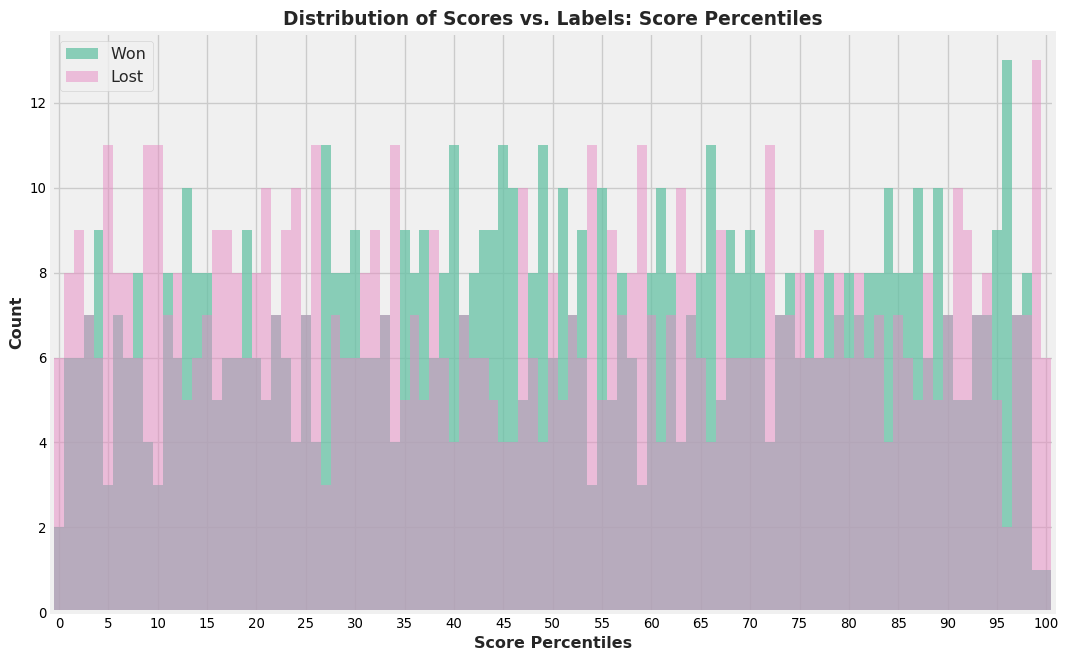

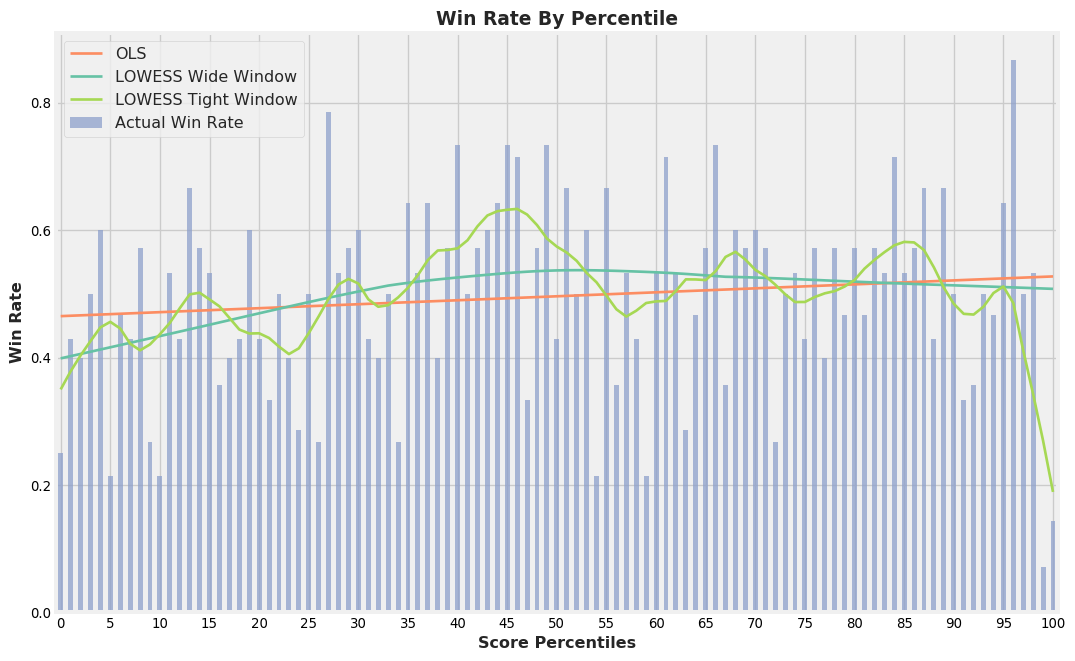

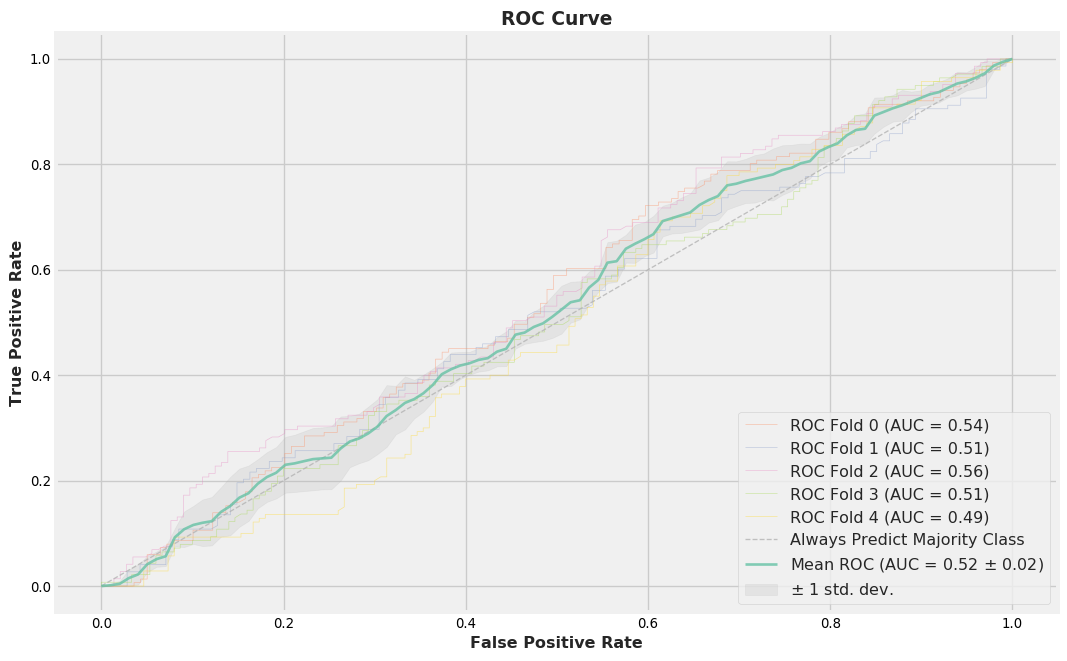

In [38]:
plot_by_threshold(scores_df, 'Accuracy')
plot_by_threshold(scores_df, 'F1')

binned_data = {}
for bin_type in bin_types:
    binned_data[bin_type] = {}
    for nbins in plot_bins:
        ## plot bins
        curr_bins = compute_bins(scores_df, nbins, bin_type)
        compute_plot_bins(curr_bins, nbins, label_map, bin_type, colors)
        ## plot trend
        if bin_type == 'Percentile':
            plot_trend(curr_bins, eval_dict, bin_type, nbins)
        ## store data
        binned_data[bin_type][nbins] = curr_bins

roc_sets = {
    set_nbr: set_data['score'][['label','score']]
    for set_nbr, set_data in training_scoring_sets.iteritems()
    if set_data['score'].shape[0] > 0
}

roc_plot_kfold_errband(roc_sets)

## TODO: feature importance and contribution